In [93]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import MCMT
from math import sqrt, pow, pi

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

#Create Diffuser circuit
def diffuser(nqubits):
    qc=QuantumCircuit(n)
#diff=H^nR_oH^n
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
   #Start implementing the R_0 
    for qubit in range(nqubits):
        qc.x(qubit)
    
       # Do multi-controlled-Z gate using multicontrol multitarget gate MCMT
    cnz = MCMT('z', num_ctrl_qubits=nqubits-1, num_target_qubits=1)
    qc=qc.compose(cnz) #add cnz to the original qc
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    
    #apply xzxz to the first qubit
    qc.x(0)
    qc.z(0)
    qc.x(0)
    qc.z(0)
    # End of R_0
    
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

#Input the string size
n=6
#Create Oracle
qc = QuantumCircuit(n+1)
qc.cx(1,n) 
qc.cx(0,n) #String is equal to 110000
#qc.cz(0, 3)
oracle_exn = qc.to_gate()
oracle_exn.name = "U$_\omega$"

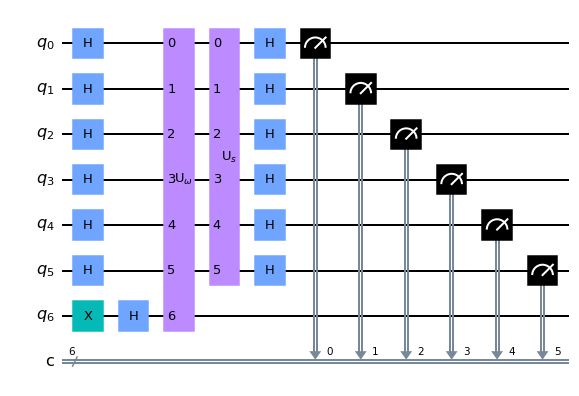

In [96]:
grover_circuit = QuantumCircuit(n+1,n)
grover_circuit.x(n) #To create the Ancilla |->
for qubit in range(n+1):
    grover_circuit.h(qubit)
  
#Number of iterations of oracle and diffuser needed
t=pi*sqrt(pow(pow(2,n),0.5))/4-0.5
t=int(t)
#grover_circuit = initialize(grover_circuit, [0,1,2])
for i in range(t):
    grover_circuit=grover_circuit.compose(oracle_exn)
    grover_circuit=grover_circuit.compose(diffuser(n))

for qubit in range(n):
    grover_circuit.h(qubit)

for i in range(n):
    grover_circuit.measure(i,i)
#grover_circuit.measure_all()
grover_circuit.draw()

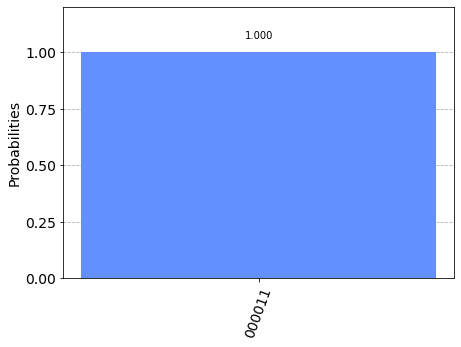

In [97]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)